In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [2]:
class AttentionEncoder(nn.Module):
    def __init__(self, input_size, T, hidden_size, dropout):
        super(AttentionEncoder, self).__init__()
        self.input_size = input_size
        self.T = T
        self.hidden_size = hidden_size
        self.dropout = dropout
        
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, dropout = self.dropout)
        # define attention layer
        self.linear = nn.Linear(self.T + self.hidden_size * 2, self.T, False)
        self.linear2 = nn.Linear(self.T, 1, False)
        
    def forward(self, x):
        # note that input x has dimension of batch * T * input_size, and hidden is batch * hidden_size
        batch_size = x.shape[0]
        h = self.init_state(batch_size, self.hidden_size)
        c = self.init_state(batch_size, self.hidden_size)
        h_out=torch.zeros(self.T, batch_size, self.hidden_size, device = device)
        
        for i in range(self.T):
            # first calculate input attention
            concat_hc = torch.cat((h, c), 2).permute(1,0,2).repeat(1, self.input_size, 1)
            # concat_hc has a size of batch_size * input_size * 2 hidden_size
            out = self.linear(torch.cat((concat_hc, x.permute(0, 2, 1)), 2))
            # out has a dimension of (batch_size*input_size) * T
            weight = self.linear2(torch.tanh(out)).view(batch_size, self.input_size)
            weight = torch.softmax(weight, 1)
            # weight has a size of batch * input_size
            
            # update h and c
            _, new_state = self.lstm((x[:,i,:] * weight).unsqueeze(0), (h, c))
            h, c = new_state
            h_out[i] = h[0]
        return h_out
    def init_state(self, batch_size, hidden_size):
        return torch.zeros(1, batch_size, hidden_size, device=device)
    def init_weight(self, T, batch_size, input_size):
        return torch.zeros(1, T, batch_size, input_size, device=device)

In [3]:
class AttentionDecoder(nn.Module):
    def __init__(self, input_size, T, hidden_size, dropout):
        super(AttentionDecoder, self).__init__()
        # input size = 1 + m, here m is h state dimension
        self.input_size = input_size
        self.T = T
        self.hidden_size = hidden_size
        self.dropout = dropout
        
        # use nn.ModuleList for customized sequential layers
        self.lstm = nn.LSTM(1, self.hidden_size, dropout = self.dropout)
        # define attention layers which are linear of tanh layers
        self.linear = nn.Linear(self.input_size - 1 + self.hidden_size * 2, self.input_size - 1, False)
        self.v = nn.Linear(self.input_size - 1, 1, False)
        self.linear2 = nn.Linear(self.input_size, 1)
        self.linear3 = nn.Linear(self.hidden_size + self.input_size - 1, self.hidden_size)
        self.linear4 = nn.Linear(self.hidden_size, 1)
    def forward(self, y, h):
        batch_size = y.shape[0]
        d=self.init_state(batch_size,self.hidden_size)
        s=self.init_state(batch_size,self.hidden_size)
        # note that input y: batch * T * 1, h: T * batch * m, hidden state d: batch * hidden_size
        for i in range(self.T):
            # first calculate temporal attention on h from encoder
            concat_ds = torch.cat((d, s), 2).permute(1, 0, 2).repeat(1, self.T, 1)
            out = self.linear(torch.cat((concat_ds, h.permute(1, 0, 2)), 2))
            weight = self.v(torch.tanh(out)).view(batch_size, self.T)
            weight = torch.softmax(weight, 1)
            weight = weight.unsqueeze(1)
            # new h after temporal attention, batch_size * hidden
            new_h = torch.bmm(weight, h.permute(1, 0, 2)).squeeze(1)
            # update d and s
            _, new_state = self.lstm((self.linear2(torch.cat((y[:,i,:], new_h), 1))).unsqueeze(0), (d, s))
            d, s = new_state
    
        y_out = self.linear4(self.linear3(torch.cat((d.squeeze(0), new_h), 1)))
        return y_out
    def init_state(self, batch_size, hidden_size):
        return torch.zeros(1, batch_size, hidden_size, device=device)
    def init_weight(self, T, batch_size):
        return torch.zeros(1, batch_size, T, device=device)   

In [4]:
def Train(Encoder, Decoder, Train_generator, Eval_X, Eval_Y, config, optimizer, criterion, print_num, EarlyStopping=None):
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)
    Train_loss, Val_loss = [], []
    Eval_X1, Eval_X2 = torch.split(Eval_X, [Eval_X.shape[2] - 1, 1], dim=2)
    if EarlyStopping:
        count = 0
        best_loss = float('inf')
    for epoch in range(config.epoch):
        tic = time.time()
        # Training
        num = 0
        for x, y in Train_generator:
            x1, x2 = torch.split(x, [x.shape[2] - 1, 1], dim=2)
            optimizer.zero_grad()
            y_pred = Decoder(x2, Encoder(x1))
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            if num%print_num == 0:
                print(loss)
            num += 1
        Train_loss.append(loss)
        # Validation
        with torch.no_grad():
            y_pred = Decoder(Eval_X2, Encoder(Eval_X1))
        Val_loss.append(criterion(y_pred, Eval_Y))
        print('Epoch = %d, Time elapsed = %d s, Train loss = %f, Val loss = %f' 
              % (epoch + 1, time.time() - tic, Train_loss[-1], Val_loss[-1]))
        if EarlyStopping:
            if Val_loss[-1] < best_loss:
                best_loss = Val_loss[-1]
                count = 0
            elif count >= EarlyStopping:
                break
            else:
                count += 1
        scheduler.step()
    return Train_loss, Val_loss

def predict(Encoder, Decoder, X):
    X1, X2 = torch.split(X, [X.shape[2] - 1, 1], dim=2)
    with torch.no_grad():
        y_pred = Decoder(X2, Encoder(X1))
    return y_pred     

In [5]:
class parameter:
    T_grid = [10]
    m_grid = [128]
    batch_size = 256
    epoch = 50
    learning_rate = 0.001
    Test_num = 2700
    print_num = 50
    dropout = 0
config = parameter()

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data =  pd.read_csv('./nasdaq100/small/nasdaq100_padding.csv').values
data.shape

(40560, 82)

In [7]:
percentage = False
if percentage:
    for i in range(data.shape[0] - 1, 0, -1):
        data[i] = (data[i] - data[i-1])/data[i-1]
    data = data[1:]
scale = StandardScaler().fit(data)
data = scale.transform(data)
data = torch.from_numpy(data).float()
data.shape

torch.Size([40560, 82])

tensor(0.7657, grad_fn=<MseLossBackward>)
tensor(0.6958, grad_fn=<MseLossBackward>)
tensor(0.2794, grad_fn=<MseLossBackward>)
tensor(0.0164, grad_fn=<MseLossBackward>)
tensor(0.0072, grad_fn=<MseLossBackward>)
tensor(0.0036, grad_fn=<MseLossBackward>)
Epoch = 1, Time elapsed = 88 s, Train loss = 0.003068, Val loss = 0.004075
tensor(0.0032, grad_fn=<MseLossBackward>)
tensor(0.0031, grad_fn=<MseLossBackward>)
tensor(0.0088, grad_fn=<MseLossBackward>)
tensor(0.0037, grad_fn=<MseLossBackward>)
tensor(0.0041, grad_fn=<MseLossBackward>)
tensor(0.0023, grad_fn=<MseLossBackward>)
Epoch = 2, Time elapsed = 89 s, Train loss = 0.005188, Val loss = 0.004405
tensor(0.0041, grad_fn=<MseLossBackward>)
tensor(0.0037, grad_fn=<MseLossBackward>)
tensor(0.0028, grad_fn=<MseLossBackward>)
tensor(0.0034, grad_fn=<MseLossBackward>)
tensor(0.0054, grad_fn=<MseLossBackward>)
tensor(0.0033, grad_fn=<MseLossBackward>)
Epoch = 3, Time elapsed = 90 s, Train loss = 0.002083, Val loss = 0.004317
tensor(0.0047, grad

Epoch = 25, Time elapsed = 130 s, Train loss = 0.000927, Val loss = 0.001094
tensor(0.0007, grad_fn=<MseLossBackward>)
tensor(0.0008, grad_fn=<MseLossBackward>)
tensor(0.0009, grad_fn=<MseLossBackward>)
tensor(0.0010, grad_fn=<MseLossBackward>)
tensor(0.0009, grad_fn=<MseLossBackward>)
tensor(0.0020, grad_fn=<MseLossBackward>)
Epoch = 26, Time elapsed = 107 s, Train loss = 0.000955, Val loss = 0.000853
tensor(0.0009, grad_fn=<MseLossBackward>)
tensor(0.0012, grad_fn=<MseLossBackward>)
tensor(0.0006, grad_fn=<MseLossBackward>)
tensor(0.0007, grad_fn=<MseLossBackward>)
tensor(0.0023, grad_fn=<MseLossBackward>)
tensor(0.0014, grad_fn=<MseLossBackward>)
Epoch = 27, Time elapsed = 96 s, Train loss = 0.000425, Val loss = 0.000838
tensor(0.0013, grad_fn=<MseLossBackward>)
tensor(0.0007, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(0.0006, grad_fn=<MseLossBackward>)
tensor(0.0020, grad_fn=<MseLossBackward>)
Epoch = 28, Ti

tensor(0.0004, grad_fn=<MseLossBackward>)
Epoch = 50, Time elapsed = 93 s, Train loss = 0.000442, Val loss = 0.000719


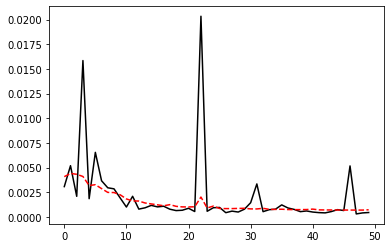

In [8]:
criterion = nn.MSELoss()
loss = np.zeros((len(config.T_grid), len(config.m_grid)))
N = data.shape[0]
Model_list=[]
for i, T in enumerate(config.T_grid):
    for j, m in enumerate(config.m_grid):
        data_Y = data[T:, -1].unsqueeze(1)
        data_X = torch.zeros(N - T, T, data.shape[1])
        for index in range(N - T):
            data_X[index,:,:] = data[index:index + T]
        
        Train_X, Test_X = data_X.split([N - T - config.Test_num, config.Test_num], dim = 0)
        Train_Y, Test_Y = data_Y.split([N - T - config.Test_num, config.Test_num])
        Train_X, Eval_X, Train_Y, Eval_Y = train_test_split(Train_X, Train_Y, test_size=0.2)
        dataset_Train = torch.utils.data.TensorDataset(Train_X, Train_Y)
        Train_generator = DataLoader(dataset_Train, batch_size=config.batch_size, shuffle=True, pin_memory=True)
        Encoder = AttentionEncoder(data.shape[1] - 1, T, m, dropout = config.dropout).to(device)
        Decoder = AttentionDecoder(1 + m, T, m, dropout = config.dropout).to(device)
        optimizer = optim.Adam(list(Encoder.parameters()) + list(Decoder.parameters()), lr=config.learning_rate, weight_decay = 0)
        # Training
        Train_loss, Val_loss = Train(Encoder, Decoder, Train_generator, Eval_X, Eval_Y, config, optimizer, criterion, 20, 6)
        plt.figure()
        plt.plot(Train_loss, 'k', Val_loss, 'r--')
        plt.show()
        Model_list.append([Encoder, Decoder])
        # Eval
        loss[i][j] = Val_loss[-1]

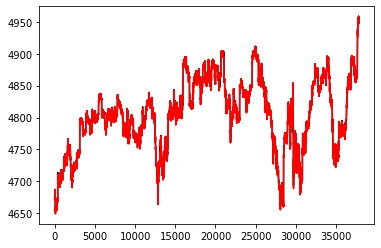

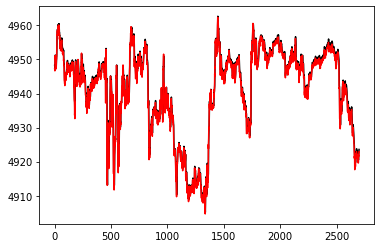

In [9]:
min_idx = np.argmin(loss)
i, j = min_idx//len(config.m_grid), min_idx%len(config.m_grid)
T, m = config.T_grid[i], config.m_grid[j]
data_Y = data[T:, -1].unsqueeze(1)
data_X = torch.zeros(N - T, T, data.shape[1])
for index in range(N - T):
    data_X[index,:,:] = data[index:index + T]
Train_X, Test_X = data_X.split([N - T - config.Test_num, config.Test_num], dim = 0)
Train_Y, Test_Y = data_Y.split([N - T - config.Test_num, config.Test_num])

# Test
Encoder, Decoder = Model_list[min_idx]
# first see Train data prediction
Train_Y_pred = predict(Encoder, Decoder, Train_X)
plt.figure()
plt.plot(scale.inverse_transform(Train_Y_pred.cpu().repeat(1,82).numpy())[:,-1],'k',scale.inverse_transform(Train_Y.repeat(1,82).numpy())[:,-1],'r')
# see the prediction of new data
Test_Y_pred = predict(Encoder, Decoder, Test_X)
plt.figure()
plt.plot(scale.inverse_transform(Test_Y_pred.cpu().repeat(1,82).numpy())[:,-1],'k',scale.inverse_transform(Test_Y.repeat(1,82).numpy())[:,-1],'r')